# Multivariate TDE-HMM on all subjects, following Quinn's method

## Libraries and methods

In [1]:
import numpy as np
from loader import load_oneIC
import h5py
import xarray as xr

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from hmmlearn import hmm
import scipy.signal as signal
import pickle

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from wavelet_transform import wavelet_transform2

In [4]:
import mne

In [5]:
import time as tm

In [6]:
directory = "/home/INT/malfait.n/Documents/NIC_250819"
file = "FCK_LOCKED_IC_JYOTIKA_250819.mat"

path = f"{directory}/{file}"

mat_file = h5py.File(path, "r")
cells_refs = mat_file['FCK_LOCKED_IC_JYOTIKA']

n_IC = 4
n_subj = 23

In [7]:
target_dir = "tde-hmm2/test_grids/"

## Functions

In [8]:
# # The embedx function copies the `x` array len(lags) times into `xe`
# # with lags (i.e. time delays) between lags[0] and lags[-1] (we implement the time-delay array for the HMM).

# def embedx(x, lags):
    
#     Xe = np.zeros((x.shape[1], x.shape[0],  len(lags)))

#     for l in range(len(lags)):
#         Xe[:, :, l] = np.roll(x, lags[l], axis=0).swapaxes(0, 1)

#     # Remove edges
#     valid = np.ones((x.shape[0], 1), dtype=np.int8)
#     valid[:np.abs(np.min(lags)), :] = 0
#     valid[-np.abs(np.max(lags)):, :] = 0

#     Xe = Xe[:, valid[:, 0] == 1, :]

#     return Xe, valid


# # The hmm_tde function finds parameters for the HMM,
# # then uses them to determine the probability of presence of each found state over time.

# # def hmm_tde(y: np.array, n_states=3, n_iter=100, n_components=8, 
# #             covariance_type='full', model_type='GMMHMM', tol=0.01, n_mix=1, **kwargs):
    
# #     if model_type=='GMMHMM':
# #         model = hmm.GMMHMM(n_components=n_states, n_iter=n_iter,
# #                             covariance_type=covariance_type, tol=tol, n_mix=n_mix, **kwargs)
        
# #     elif model_type=='GaussianHMM':
# #         model = hmm.GaussianHMM(n_components=n_states, n_iter=n_iter,
# #                             covariance_type=covariance_type, tol=tol, **kwargs)
        
# #     elif model_type=='MultinomialHMM':
# #         model = hmm.MultinomialHMM(n_components=n_states, n_iter=n_iter, tol=tol, **kwargs)
    
# #     else: 
# #         return "Non-exixting model_type. Please choose 'GMMHMM' or 'GaussianHMM' or 'MultinomialHMM'. default='GMMHMM'"
        
# #     model.fit(y)
# #     gamma = model.predict_proba(y)

# #     return gamma, model

In [9]:
# The embedx function copies the `x` array len(lags) times into `xe`
# with lags (i.e. time delays) between lags[0] and lags[-1] (we implement the time-delay array for the HMM).

def embedx(x, lags):
    
    Xe = np.zeros((x.shape[1], x.shape[0],  len(lags)))

    for l in range(len(lags)):
        Xe[:, :, l] = np.roll(x, lags[l], axis=0).swapaxes(0, 1)

    # Remove edges
    valid = np.ones((x.shape[0], 1), dtype=np.int8)
    valid[:np.abs(np.min(lags)), :] = 0
    valid[-np.abs(np.max(lags)):, :] = 0

    Xe = Xe[:, valid[:, 0] == 1, :]

    return Xe, valid

In [10]:
def statesPSD(gamma, n_states, xe, fs=256/3):

    psd_all = []
    for i in range(n_states):

        # Compute PSD separately for each lag
        tot = []
        for seg in xe[gamma[:, i]>(2/3), :].T:
            freqs, psd = signal.welch(x=seg, fs=fs, nfft=1000)
            tot.append(psd)
        psd = np.mean(np.asarray(tot), 0)
        psd_all.append(psd)
    
    psd_all = np.asarray(psd_all)
    
    return freqs, psd_all

## Final Script

#### Model and parameters:
|_ (??delays x 4IC)  x (7s x 256Hz x Ntrials)   -----PCA-----> |_ (??components x 4IC) x (7s x 256Hz x Ntrials) -----> |_ TDE-HMM ( 1 Gaussian/state, 3 to 6 states )

In [11]:
# The parameters we change to hope for some results
lags = np.arange(-5, 5)
n_lags = lags.shape[0]
n_iter=100
n_states_max=6    # for the Hidden Markov Model
n_components=0     # For the principal component analysis
covariance_type='full'
model_type='GaussianHMM'
tol=0.01
n_mix=1
downsamp_rate = 3

In [46]:
subj_list = [2, 3, 4, 6, 7, 8, 10, 11, 14, 16, 18, 19, 22]

In [47]:
subj_lengths = []
tde_imput = []
new_subj_list = []
for subj in subj_list:
    # Loading all data for subject{subj}
    print("Computing the imput matrix for the model")
    xeall = []
    IC_list = []
    for IC in range(1, n_IC+1):
        data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
        big_timecourse = np.concatenate([data[f'raw_timecourse_256Hz'][i][::downsamp_rate] for i in range(100)])
            # Downsampled to 256/3 = 85,33333Hz
        big_timecourse = scale(big_timecourse)
        x = big_timecourse.reshape(-1, 1)
        xe, valid = embedx(x, lags)
        xeall.append(xe[0, :, :])
        IC_list.append(IC)
        print(f"IC{IC} loaded")
    y = np.concatenate(xeall, axis=1)
    tde_imput.append(y)
    subj_lengths.append(xe.shape[1])
    new_subj_list.append(subj)
tde_imput = np.concatenate(tde_imput)

Computing the imput matrix for the model
Loading the raw timecourse
IC1 loaded
Loading the raw timecourse
IC2 loaded
Loading the raw timecourse
IC3 loaded
Loading the raw timecourse
IC4 loaded
Computing the imput matrix for the model
Loading the raw timecourse
IC1 loaded
Loading the raw timecourse
IC2 loaded
Loading the raw timecourse
IC3 loaded
Loading the raw timecourse
IC4 loaded
Computing the imput matrix for the model
Loading the raw timecourse
IC1 loaded
Loading the raw timecourse
IC2 loaded
Loading the raw timecourse
IC3 loaded
Loading the raw timecourse
IC4 loaded
Computing the imput matrix for the model
Loading the raw timecourse
IC1 loaded
Loading the raw timecourse
IC2 loaded
Loading the raw timecourse
IC3 loaded
Loading the raw timecourse
IC4 loaded
Computing the imput matrix for the model
Loading the raw timecourse
IC1 loaded
Loading the raw timecourse
IC2 loaded
Loading the raw timecourse
IC3 loaded
Loading the raw timecourse
IC4 loaded
Computing the imput matrix for the 

In [48]:
tde_imput.shape

(777283, 40)

In [49]:
len(new_subj_list)

13

In [50]:
print(len(subj_lengths), sum(subj_lengths))

13 777283


In [51]:
for n_states in [4,5,6]:
    start_time = tm.time()
    print("Computing and saving the model")
    model = hmm.GaussianHMM(n_components=n_states, n_iter=n_iter,
                            covariance_type=covariance_type, tol=tol)
    model.fit(tde_imput, subj_lengths)
    # gamma = model.predict_proba(y)
    with open(f"tde-hmm2/test_files/suAll_lg{n_lags}co{n_components}st{n_states}"
        +f"{n_mix}"+model_type+"_woPCA_preModel.pkl", "wb") as file: pickle.dump(model, file)
    print("%s seconds" % (tm.time() - start_time))

Computing and saving the model
13243.292280197144 seconds
Computing and saving the model
2728.0732328891754 seconds
Computing and saving the model
3897.7819356918335 seconds


In [41]:
subj_list = new_subj_list

In [42]:
subj_list

[2, 3, 4, 6, 7, 8, 10, 11, 14, 16, 18, 19, 22]

In [ ]:
n_states = 3

In [43]:
for subj in subj_list:
    start_time = tm.time()
    # Loading all data for subject{subj}
    print("Computing the imput matrix for the model")
    xeall = []
    IC_list = []
    for IC in range(1, n_IC+1):
            try:
                data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
                big_timecourse = np.concatenate([data[f'raw_timecourse_256Hz'][i][::downsamp_rate] for i in range(n_trials)])
                    # Downsampled to 256/3 = 85,33333Hz
                big_timecourse = scale(big_timecourse)
                x = big_timecourse.reshape(-1, 1)
                xe, valid = embedx(x, lags)
                xeall.append(xe[0, :, :])
                IC_list.append(IC)
                print(f"IC{IC} loaded")
            except:
                pass
    y = np.concatenate(xeall, axis=1)
    gamma = model.predict_proba(y)
    print("Computing the PSD of each state")
    psds = []
    for i in range(len(IC_list)):
        freqs, psd = statesPSD(gamma, n_states, xeall[i])
        psd = psd[np.newaxis,]
        psds.append(psd)
    # Save the states timecourses and PSDs thanks to xarray and netCDF
    print("Saving the states timecourses and PSDs")
    tcourse = np.concatenate(
        (np.zeros((abs(lags[0]),n_states)), gamma, np.zeros((lags[-1],n_states)))
    )
    time_axis = data["time_axis"][::downsamp_rate]
    t_len = time_axis.shape[0]
    tcourse_trials = np.zeros((n_trials, t_len, n_states))
    for tr in range(n_trials):
        tcourse_trials[tr] = tcourse[tr*t_len:(tr+1)*t_len]
    ds = xr.Dataset(
        {
            "states_timecourse": (("trials","time", "states"), tcourse_trials),
            "states_psd": (("IC", "states", "freq"), np.concatenate((psds))),
        },
        {
            "IC":IC_list,
            "time":time_axis,
            "states":np.arange(1, n_states+1),
            "freq": freqs,
        }
    )
    ds = ds.assign(frac_occ = (ds["states_timecourse"].sum("trials")/ds.sizes["trials"]))
    ds.to_netcdf(f"tde-hmm2/test_files/su{subj}-{n_states}states_woPCA_preModel_data_Multi.nc")
    
    
    print(f"subj{subj}: OK")
    
    print("%s seconds" % (tm.time() - start_time))

Computing the imput matrix for the model
Loading the raw timecourse
IC1 loaded
Loading the raw timecourse
IC2 loaded
Loading the raw timecourse
IC3 loaded
Loading the raw timecourse
IC4 loaded
Computing the PSD of each state
Saving the states timecourses and PSDs
subj2: OK
2.8892722129821777 seconds
Computing the imput matrix for the model
Loading the raw timecourse
IC1 loaded
Loading the raw timecourse
IC2 loaded
Loading the raw timecourse
IC3 loaded
Loading the raw timecourse
IC4 loaded
Computing the PSD of each state
Saving the states timecourses and PSDs
subj3: OK
3.0071909427642822 seconds
Computing the imput matrix for the model
Loading the raw timecourse
IC1 loaded
Loading the raw timecourse
IC2 loaded
Loading the raw timecourse
IC3 loaded
Loading the raw timecourse
IC4 loaded
Computing the PSD of each state
Saving the states timecourses and PSDs
subj4: OK
3.3936498165130615 seconds
Computing the imput matrix for the model
Loading the raw timecourse
IC1 loaded
Loading the raw ti

In [44]:
widths = [14, 1, 5]
heights = [1,1,1,4,4,4,4]
gs_kw = dict(width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)
info = mne.create_info(ch_names=['signal'], sfreq=256, ch_types=['eeg'])
for subj in subj_list:
    fig, f_axes = plt.subplots(figsize=(sum(widths),sum(heights)), ncols=3, nrows=(n_states+4), constrained_layout=True,
                             gridspec_kw=gs_kw)
    ds = xr.open_dataset(f"tde-hmm2/test_files/su{subj}-{n_states}states_woPCA_preModel_data_Multi.nc")
    for state in ds["states"].values:
        ax = f_axes[state-1,0]
    #         ax.set_xticks([])
        ax.plot(ds["time"].values, ds["frac_occ"].values[:, state-1], color=f"C{state-1}")
        ax.set_xlim([-4, 3])
        ax.set_ylabel(f"state {state}")
    for IC in ds["IC"].values:
        ax = f_axes[IC+n_states-1,0]
        data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
        tfr = wavelet_transform2(data, info, trial=np.arange(1,n_trials+1))
        mappable = ax.imshow(tfr[0], aspect='auto', origin='lower', extent=[-4, 3, 2, 50], 
                               norm=colors.PowerNorm(gamma=0.5), cmap='RdYlBu_r')
        ax.set_ylabel(f'Frequencies IC{IC} (Hz)')
        fig.colorbar(mappable, cax=f_axes[IC+n_states-1,1])
    #         if IC!=4:
    #             ax.set_xticks([])
    for i in range(len(ds["IC"].values)):
        IC = ds["IC"].values[i]
        ax = f_axes[IC+n_states-1,2]
        ax.plot(ds["freq"].values, ds["states_psd"].values[i,].T)
        ax.set_ylabel(f'PSD IC{IC}')
    ax = f_axes[n_states,2]
    lines = ax.get_lines()
    labels = [f"State {i}" for i in range (1, n_states+1)]
    ax = f_axes[0,2]
    ax.legend(lines, labels, loc='upper left')
    ax = f_axes[n_states+3,0]
    ax.set_xlabel(f'Time (s)') 
    ax = f_axes[n_states+3,2]
    ax.set_xlabel(f'Frequency (Hz)')   

    fig.savefig(target_dir + f'grid-{n_states}states-subj{subj}_woPCA_preModel.png', dpi=300)
    plt.close(fig)

Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
L

In [45]:
n_trials_to_plot = 5
for subj in subj_list:
    fig, f_axes = plt.subplots(figsize=(20,n_states*n_trials_to_plot), ncols=1, nrows=(n_states*n_trials_to_plot), constrained_layout=True)
    ds = xr.open_dataset(f"tde-hmm2/test_files/su{subj}-{n_states}states_woPCA_preModel_data_Multi.nc")
    for state in range(1, n_states+1):
        color = f"C{state-1}"
        for trial in range(1, n_trials_to_plot+1):
            ax = f_axes[n_trials_to_plot*(state-1)+trial-1]
            ax.fill_between(ds["time"], ds["states_timecourse"].values[trial, :, state-1], color=color)
            ax.set_xlim([-4, 3])
            ax.set_ylim([0, 1])
            ax.set_ylabel(f"Prob. st{state} tr{trial}")
    ax.set_xlabel("Time (s)")
    fig.savefig(target_dir + f'tcourses-{n_states}states-subj{subj}_woPCA_preModel.png', dpi=300)
    plt.close(fig)

## Tests

In [14]:
subj = 2
freqs = np.arange(0, 50, 50/196)

In [15]:
n_states = 3

In [16]:
for IC in range(1, n_IC+1):
#             try:
    data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
    big_timecourse = np.concatenate([data[f'raw_timecourse_256Hz'][i][::downsamp_rate] for i in range(100)])
        # Downsampled to 256/3 = 85,33333Hz
    big_timecourse = scale(big_timecourse)
    x = big_timecourse.reshape(-1, 1)
    xe, valid = embedx(x, lags)
    xeall.append(xe[0, :, :])
    IC_list.append(IC)
    print(f"IC{IC} loaded")
#             except:
#                 pass

Loading the raw timecourse
IC1 loaded
Loading the raw timecourse
IC2 loaded
Loading the raw timecourse
IC3 loaded
Loading the raw timecourse
IC4 loaded


In [21]:
len(xeall)

4

In [20]:
IC_list

[1, 2, 3, 4]

##### Concatenate all subjects and create array with sizes

In [38]:
subj_lengths = []
tde_imput = []

In [39]:
# Loading all data for subject{subj}
print("Computing the imput matrix for the model")
xeall = []
IC_list = []
for IC in range(1, n_IC+1):
#         try:
        data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
        big_timecourse = np.concatenate([data[f'raw_timecourse_256Hz'][i][::downsamp_rate] for i in range(n_trials)])
            # Downsampled to 256/3 = 85,33333Hz
        big_timecourse = scale(big_timecourse)
        x = big_timecourse.reshape(-1, 1)
        xe, valid = embedx(x, lags)
        xeall.append(xe[0, :, :])
        IC_list.append(IC)
        print(f"IC{IC} loaded")
#         except:
#             pass
y = np.concatenate(xeall, axis=1)
tde_imput.append(y)
subj_lengths.append(big_timecourse.shape[0])

Computing the imput matrix for the model
Loading the raw timecourse
IC1 loaded
Loading the raw timecourse
IC2 loaded
Loading the raw timecourse
IC3 loaded
Loading the raw timecourse
IC4 loaded


In [40]:
xeall[0].shape

(403641, 10)

In [41]:
start_time = tm.time()
print("Computing and saving the model")
model = hmm.GaussianHMM(n_components=n_states, n_iter=n_iter,
                        covariance_type=covariance_type, tol=tol)
model.fit(y)
gamma = model.predict_proba(y)
with open(f"tde-hmm2/test_files/su{subj}All_lg{n_lags}co{n_components}st{n_states}"
    +f"{n_mix}"+model_type+"_woPCA_model.pkl", "wb") as file: pickle.dump(model, file)
print("%s seconds" % (tm.time() - start_time))

Computing and saving the model
227.788507938385 seconds


In [42]:
print("Computing the PSD of each state")
psds = []
for i in range(len(IC_list)):
    freqs, psd = statesPSD(gamma, n_states, xeall[i])
    psd = psd[np.newaxis,]
    psds.append(psd)

Computing the PSD of each state


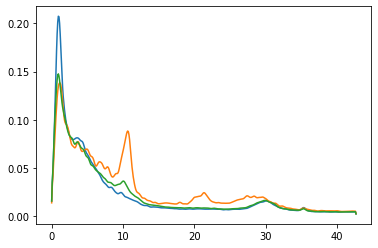

In [43]:
plt.plot(freqs, psds[0][0].T)

In [44]:
data["time_axis"][::downsamp_rate].shape

(598,)

In [45]:
(gamma.shape[0]+9)/n_trials

598.0

In [46]:
# Save the states timecourses and PSDs thanks to xarray and netCDF
print("Saving the states timecourses and PSDs")
tcourse = np.concatenate(
    (np.zeros((abs(lags[0]),n_states)), gamma, np.zeros((lags[-1],n_states)))
)
time_axis = data["time_axis"][::downsamp_rate]
t_len = time_axis.shape[0]
tcourse_trials = np.zeros((n_trials, t_len, n_states))
for tr in range(n_trials):
    tcourse_trials[tr] = tcourse[tr*t_len:(tr+1)*t_len]
ds = xr.Dataset(
    {
        "states_timecourse": (("trials","time", "states"), tcourse_trials),
        "states_psd": (("IC", "states", "freq"), np.concatenate((psds))),
    },
    {
        "IC":IC_list,
        "time":time_axis,
        "states":np.arange(1, n_states+1),
        "freq": freqs,
    }
)
ds.to_netcdf(f"tde-hmm2/test_files/su{subj}-{n_states}states_woPCA_data.nc")
print(f"subj{subj}, IC{IC}: OK")

Saving the states timecourses and PSDs
subj2, IC4: OK


In [47]:
time_axis.shape

(598,)

In [48]:
ds

<xarray.Dataset>
Dimensions:            (IC: 4, freq: 501, states: 3, time: 598, trials: 675)
Coordinates:
  * IC                 (IC) int64 1 2 3 4
  * time               (time) float64 -4.0 -3.988 -3.977 ... 2.973 2.984 2.996
  * states             (states) int64 1 2 3
  * freq               (freq) float64 0.0 0.08533 0.1707 ... 42.5 42.58 42.67
Dimensions without coordinates: trials
Data variables:
    states_timecourse  (trials, time, states) float64 0.0 0.0 0.0 ... 0.0 0.0
    states_psd         (IC, states, freq) float64 0.0153 0.03468 ... 0.001337

In [49]:
ds = xr.open_dataset(f"tde-hmm2/test_files/su{subj}-{n_states}states_woPCA_data.nc")
ds = ds.assign(frac_occ = (ds["states_timecourse"].sum("trials")/ds.sizes["trials"]))

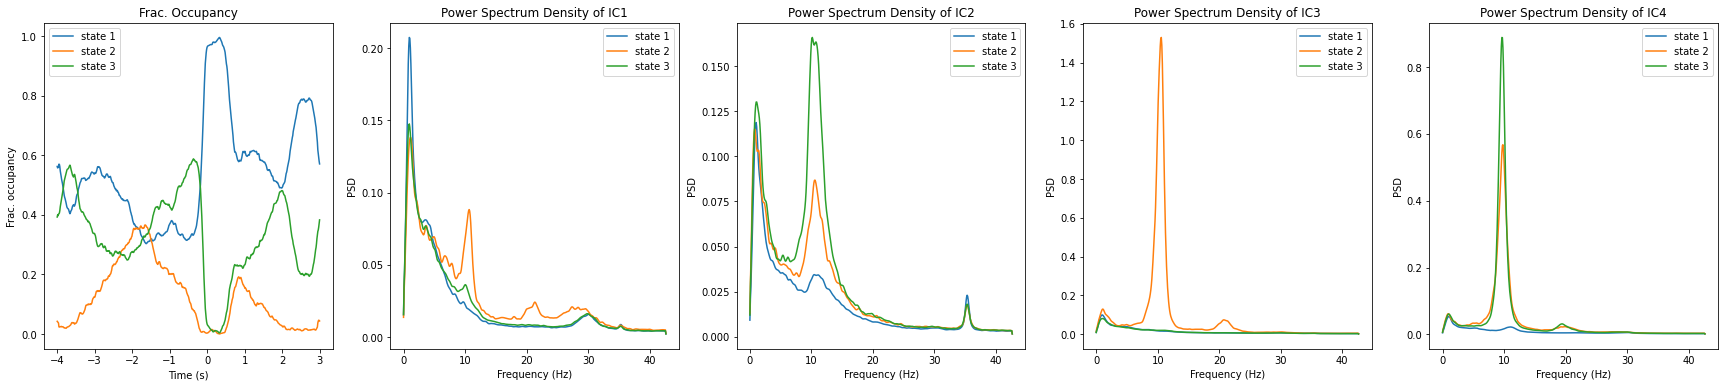

In [50]:
labels = [f"state {state}" for state in ds["states"].values]
fig = plt.figure(figsize=(6*(len(ds["IC"].values)+1),6))
plt.subplot(1, len(ds["IC"].values)+1, 1)
plt.title(f'Frac. Occupancy')
plt.plot(ds["time"].values, ds["frac_occ"].values)
plt.xlabel('Time (s)')
plt.ylabel('Frac. occupancy')
plt.legend(labels, loc='upper left')
for i in range(len(ds["IC"].values)):
    plt.subplot(1, len(ds["IC"].values)+1, i+2)
    plt.title(f"Power Spectrum Density of IC{ds['IC'].values[i]}")
    plt.plot(ds["freq"], ds["states_psd"].values[i,].T)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.legend(labels, loc='upper right')

In [51]:
ds.to_netcdf(f"tde-hmm2/test_files/su{subj}-{n_states}states_woPCA_data_Multi.nc", mode="w")
print(f"su{subj}, {n_states} states done")

su2, 3 states done


In [52]:
widths = [14, 1, 5]
heights = [1,1,1,4,4,4,4]

In [53]:
gs_kw = dict(width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)

info = mne.create_info(ch_names=['signal'], sfreq=256/downsamp_rate, ch_types=['eeg'])

In [54]:
fig, f_axes = plt.subplots(figsize=(sum(widths),sum(heights)), ncols=3, nrows=(n_states+4), constrained_layout=True,
                         gridspec_kw=gs_kw)
ds = xr.open_dataset(f"tde-hmm2/test_files/su{subj}-{n_states}states_woPCA_data_Multi.nc")
for state in ds["states"].values:
    ax = f_axes[state-1,0]
#         ax.set_xticks([])
    ax.plot(ds["time"].values, ds["frac_occ"].values[:, state-1], color=f"C{state-1}")
    ax.set_xlim([-4, 3])
    ax.set_ylabel(f"state {state}")
for IC in ds["IC"].values:
    ax = f_axes[IC+n_states-1,0]
    data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
    tfr = wavelet_transform2(data, info, trial=np.arange(1,n_trials+1))
    mappable = ax.imshow(tfr[0], aspect='auto', origin='lower', extent=[-4, 3, 2, 50], 
                           norm=colors.PowerNorm(gamma=0.5), cmap='RdYlBu_r')
    ax.set_ylabel(f'Frequencies IC{IC} (Hz)')
    fig.colorbar(mappable, cax=f_axes[IC+n_states-1,1])
#         if IC!=4:
#             ax.set_xticks([])
for i in range(len(ds["IC"].values)):
    IC = ds["IC"].values[i]
    ax = f_axes[IC+n_states-1,2]
    ax.plot(ds["freq"].values, ds["states_psd"].values[i,].T)
    ax.set_ylabel(f'PSD IC{IC}')
ax = f_axes[n_states,2]
lines = ax.get_lines()
labels = [f"State {i}" for i in range (1, n_states+1)]
ax = f_axes[0,2]
ax.legend(lines, labels, loc='upper left')
ax = f_axes[n_states+3,0]
ax.set_xlabel(f'Time (s)') 
ax = f_axes[n_states+3,2]
ax.set_xlabel(f'Frequency (Hz)')   

fig.savefig(target_dir + f'grid-{n_states}states-subj{subj}_woPCA.png', dpi=300)
plt.close(fig)

Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse


In [55]:
n_trials_to_plot = 5

In [56]:
fig, f_axes = plt.subplots(figsize=(20,n_states*n_trials_to_plot), ncols=1, nrows=(n_states*n_trials_to_plot), constrained_layout=True)
ds = xr.open_dataset(f"tde-hmm2/test_files/su{subj}-{n_states}states_woPCA_data_Multi.nc")
for state in range(1, n_states+1):
    color = f"C{state-1}"
    for trial in range(1, n_trials_to_plot+1):
        ax = f_axes[n_trials_to_plot*(state-1)+trial-1]
        ax.fill_between(ds["time"], ds["states_timecourse"].values[trial, :, state-1], color=color)
        ax.set_xlim([-4, 3])
        ax.set_ylim([0, 1])
        ax.set_ylabel(f"Prob. st{state} tr{trial}")
ax.set_xlabel("Time (s)")
fig.savefig(target_dir + f'tcourses-{n_states}states-subj{subj}_woPCA.png', dpi=300)
plt.close(fig)